# Privacy-Utility trade-off for code completion

The task is to measure and plot the privacy-utility trade-off for code completion. We will use the first 20 examples from the `openai/openai_humaneval` test split.

In [1]:
!pip install torchmetrics
import re
import random
import string
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import ast
!pip install astor
import astor

## Obfuscation functions

First, let us create two obfuscation functions: `low_obfuscation` (rename parameters) and `high_obfuscation` (remove docstrings).

We define the obfuscation functions using `ast` and `astor` libraries. Visit function of `ParamRenamer` visits the function definition in python code, and changes all kinds of parameters into `p_uuid` format.

In [2]:
import ast
import astor
import uuid

class ParamRenamer(ast.NodeTransformer):
    def __init__(self):
        super().__init__()

    def visit_FunctionDef(self, node):
        # Rename parameters
        for arg in node.args.args:
            arg.arg = "p_" + uuid.uuid4().hex[:6]

        for arg in node.args.kwonlyargs:
            arg.arg = "p_" + uuid.uuid4().hex[:6]

        if node.args.vararg:
            node.args.vararg.arg = "p_" + uuid.uuid4().hex[:6]

        if node.args.kwarg:
            node.args.kwarg.arg = "p_" + uuid.uuid4().hex[:6]

        # Rename inside function body
        self.generic_visit(node)
        return node

def rename_function_params(source_code: str) -> str:
    tree = ast.parse(source_code)
    tree = ParamRenamer().visit(tree)
    return astor.to_source(tree)

In [3]:
def low_obfuscation(prompt : str) -> str:
  tree = ast.parse(prompt) # parse the python function definition
  tree = ParamRenamer().visit(tree) # rename parameters
  return astor.to_source(tree) # return obfuscated function definiton

For high obfuscation, we remove docstrings which are explanations of what the function does, including a sample input and output.


In [4]:
class RemoveFunctionDocstrings(ast.NodeTransformer):
    def visit_FunctionDef(self, node):
        # process nested functions first
        self.generic_visit(node)

        # if the first statement is a string literal - it's the docstring
        if (
            node.body and
            isinstance(node.body[0], ast.Expr) and
            isinstance(node.body[0].value, ast.Constant) and
            isinstance(node.body[0].value.value, str)
        ):
            node.body.pop(0)

        return node

    def visit_AsyncFunctionDef(self, node):
        # Same logic for async def
        self.generic_visit(node)

        if (
            node.body and
            isinstance(node.body[0], ast.Expr) and
            isinstance(node.body[0].value, ast.Constant) and
            isinstance(node.body[0].value.value, str)
        ):
            node.body.pop(0)

        return node

In [5]:
def high_obfuscation(prompt: str) -> str:
    tree = ast.parse(prompt) # parse the python function definition
    tree = RemoveFunctionDocstrings().visit(tree) # remove docstrings
    return astor.to_source(tree) # return obfuscated function definiton

Now let us load the first 20 examples from the `openai/openai_humaneval` test split and obfuscate the prompts using the obfuscation functions defined above.

In [6]:
human_eval = load_dataset("openai_humaneval")['test'][:20]

In [7]:
original_prompts = human_eval["prompt"]
low_obfuscation_prompts = list(map(low_obfuscation, original_prompts))
high_obfuscation_prompts = list(map(high_obfuscation, original_prompts))

## Code generation

Next, using a small model - `deepseek-ai/deepseek-coder-1.3b-base`, we will generate 60 completions in total by running the original, low-obfuscated, and high-obfuscated prompts for each of the 20 examples.

In [8]:
def get_predictions(data: list) -> list:
  # define the tokenizer and the model
  tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base")
  model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base")

  # Set pad_token_id and pad_token_id if not already set
  if tokenizer.pad_token_id is None:
      tokenizer.pad_token_id = 0
  if tokenizer.eos_token_id is None:
      tokenizer.eos_token_id = 2

  # Ensure the tokenizer has the pad and eos tokens
  if tokenizer.pad_token is None:
      tokenizer.add_special_tokens({'pad_token': '<pad>'})
  if tokenizer.eos_token is None:
      tokenizer.add_special_tokens({'eos_token': '</s>'})

  # Resize model embeddings if new tokens were added
  if len(tokenizer) > model.config.vocab_size:
      model.resize_token_embeddings(len(tokenizer))

  # get the tokenized inputs like input_ids and attention_mask from the tokenizer
  inputs = tokenizer(data, return_tensors="pt", padding=True, padding_side = 'left')

  # generate the predictions
  generated_ids = model.generate(**inputs,
                               max_new_tokens=100,
                               do_sample = True,
                               temperature = 0.2,
                               top_p = 0.95,
                               num_return_sequences = 1,
                               pad_token_id = tokenizer.pad_token_id,
                               eos_token_id = tokenizer.eos_token_id)

  # Strip each output's input part
  results = []
  for i in range(len(data)):
      start_idx = (inputs['attention_mask'][i] == 1).nonzero(as_tuple=True)[0][0].item() # starting index of real input
      input_len = inputs['attention_mask'][i].sum().item()     # length of real input
      # slice the generated tokens (input ends at start_idx + input_len)
      generated_tokens = generated_ids[i][start_idx+input_len:]
      text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
      results.append(text)

  return results

In [9]:
# here we generate the predictions (takes some time)
original_preds = get_predictions(original_prompts)
low_obfuscation_preds = get_predictions(low_obfuscation_prompts)
high_obfuscation_preds = get_predictions(high_obfuscation_prompts)

pytorch_model.bin:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

## Evaluation

Next, we will evaluate all 60 items by calculating a Utility score ( ROUGE score comparing the completion to the `canonical_solution`) and a Privacy score (normalized Levenshtein distance comparing the obfuscated prompt to the original).

In [10]:
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text import EditDistance
distance = EditDistance()
rouge = ROUGEScore(use_stemmer=True)

In [11]:
def calculate_rouges(preds):
  rouges = []
  for i in range(len(preds)):
    r = rouge(preds[i:i+1], human_eval["canonical_solution"][i:i+1])['rouge1_fmeasure']
    rouges.append(r)
  return rouges

original_rouges = calculate_rouges(original_preds)
low_obfuscation_rouges = calculate_rouges(low_obfuscation_preds)
high_obfuscation_rouges = calculate_rouges(high_obfuscation_preds)

NameError: name 'original_preds' is not defined

In [12]:
def calculate_distances(prompts):
  distances = []
  for i in range(len(prompts)):
    # normalize distance by dividing by the length of longest string
    dis = distance(prompts[i:i+1], original_prompts[i:i+1])/max(len(str(prompts[i:i+1])), len(str(original_prompts[i:i+1])))
    distances.append(dis)
  return distances

original_distances = calculate_distances(original_prompts) # this gives 0's because the prompts is compared to itself
low_obfuscation_distances = calculate_distances(low_obfuscation_prompts)
high_obfuscation_distances = calculate_distances(high_obfuscation_prompts)

In [13]:
rouges = original_rouges, low_obfuscation_rouges, high_obfuscation_rouges
distances = original_distances, low_obfuscation_distances, high_obfuscation_distances

NameError: name 'original_rouges' is not defined

## Visualization

Let us finally visualize the results as a scatter plot of "Privacy Score" vs. "Utility Score".

NameError: name 'rouges' is not defined

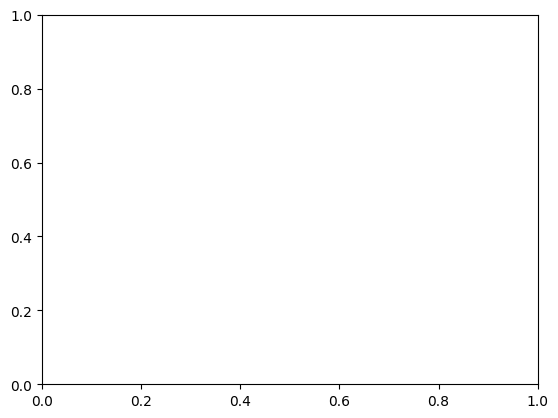

In [14]:
from matplotlib.lines import lineStyles
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
colors = mpl.color_sequences['tab20']
ax.scatter(rouges[0], distances[0], c= colors, marker = 'o', label = 'Original')
ax.scatter(rouges[1], distances[1], c = colors, marker = '^', label = 'Low Obfuscation')
ax.scatter(rouges[2], distances[2], c = colors, marker = 's', label = 'High Obfuscation')
plt.axvline(x = sum(rouges[0]) / len(rouges[0]), linestyle='--', color = 'red')
plt.axvline(x = sum(rouges[1]) / len(rouges[1]), linestyle='--', color = 'green')
plt.axvline(x = sum(rouges[2]) / len(rouges[2]), linestyle='--', color = 'blue')
ax.legend(loc="best")
plt.xlabel('Utility Score')
plt.ylabel('Privacy Score')
plt.show()

## Analysis

First, we observe that our code completion model is not quite the state-of-the-art because we are using a relatively small model.
We can see that even with non-obfuscated prompts, the model performance is unstable and average utility score (red) is around 0.36.

That said, we also plot the average utility score low obfuscated (green) and high obfuscated (blue) prompts which both are below the red - original prompts. That means, as we obfuscate the prompts to increase privacy, we lose on utility.

It is important to note that, we would expect high-obfuscated prompts have a utility score lower than the low obfuscated ones, but the opposite is observed. The reason behind it is that the docstrings that are present in low-obfuscated prompts confuse the model and model tries to complete the natural language text instead of the code. That means removing the docstrings helps the model generate more code but at the same time model struggles to correctly generate the code because it does not have enough understanding of what the function should do.